<hr>
<h3>Задание №5</h3>

<p>Напишите приложение для загрузки файлов из интернета. В главном окне должно быть три текстовых поля, в которые можно вводить URL файла на закачку; под каждым из текстовых полей должны быть индикаторы загрузки и рядом поля с процентом загрузки каждого файла. Необходимо организовать возможность качать от одного до трех файлов параллельно (использовать потоки обязательно, файлы загружать фрагментами по 4 Кб). Загрузка должна инициироваться нажатием кнопки «Start downloading!». По окончанию загрузки последнего файла должно появиться окно со столбчатой диаграммой со значениями времени загрузки каждого файла в формате «2s 322ms» и размерами файлов (используйте библиотеку matplotlib).</p>
<hr>

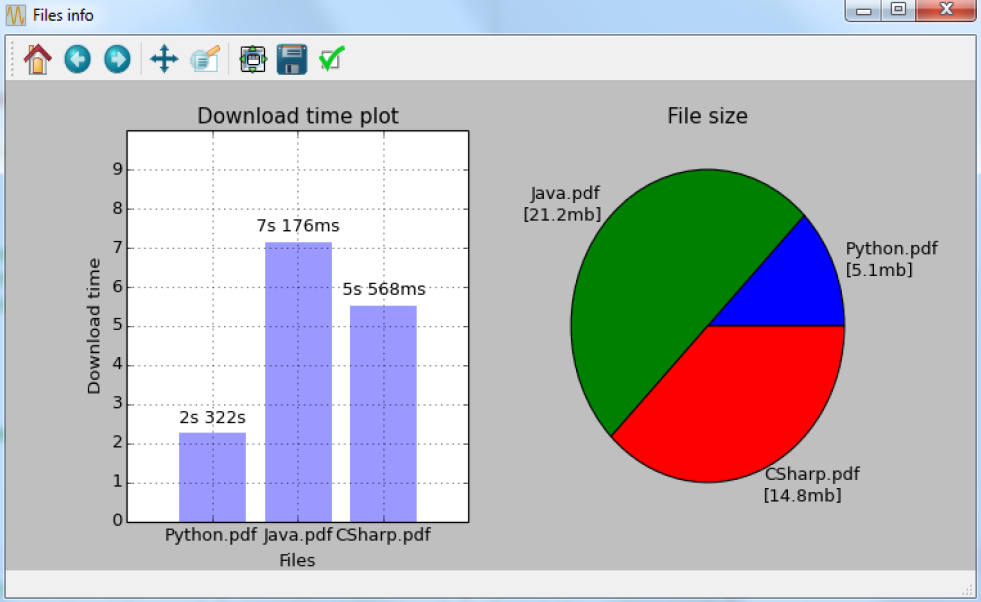
<p style="text-align: center;">Рисунок 5 – Вид окна загрузки файлов</p>

<hr>

<h4>Test Link:</h4>
<ul>
    <li><p>https://csharpcooking.github.io/theory/SchildtCSharp4.pdf</p></li>
    <li><p>http://kharchuk.ru/JavaScript.pdf</p></li>
    <li><p>http://static.infragistics.com/marketing/Website/Ignite-UI/Angular-Essentials/angularessentials.pdf</p></li>
</ul>

In [ ]:
import requests
import os
import threading
import time

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg, NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure

# Treads
from concurrent.futures import ThreadPoolExecutor

# PyQt
from PyQt5 import QtWidgets, QtCore, QtGui

In [ ]:
class MainWindow(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()
        self.plot_window = None
        self.setWindowTitle('Загрузка файлов')
        self.setGeometry(100, 100, 500, 400)
        self.setFixedSize(500, 400)

        self.url1_edit = QtWidgets.QLineEdit()
        self.url2_edit = QtWidgets.QLineEdit()
        self.url3_edit = QtWidgets.QLineEdit()

        self.progress1_bar = QtWidgets.QProgressBar()
        self.progress2_bar = QtWidgets.QProgressBar()
        self.progress3_bar = QtWidgets.QProgressBar()

        self.create_widgets()

    def create_widgets(self):
        url1_label = QtWidgets.QLabel('URL файла 1:')
        url1_layout = QtWidgets.QVBoxLayout()
        url1_layout.addWidget(url1_label)
        url1_layout.addWidget(self.url1_edit)

        progress1_layout = QtWidgets.QVBoxLayout()
        progress1_layout.addWidget(self.progress1_bar)

        url2_label = QtWidgets.QLabel('URL файла 2:')
        url2_layout = QtWidgets.QVBoxLayout()
        url2_layout.addWidget(url2_label)
        url2_layout.addWidget(self.url2_edit)

        progress2_layout = QtWidgets.QVBoxLayout()
        progress2_layout.addWidget(self.progress2_bar)

        url3_label = QtWidgets.QLabel('URL файла 3:')
        url3_layout = QtWidgets.QVBoxLayout()
        url3_layout.addWidget(url3_label)
        url3_layout.addWidget(self.url3_edit)

        progress3_layout = QtWidgets.QVBoxLayout()
        progress3_layout.addWidget(self.progress3_bar)

        download_button = QtWidgets.QPushButton('Start downloading!', self)
        download_button.clicked.connect(self.download)

        layout = QtWidgets.QVBoxLayout()
        layout.addLayout(url1_layout)
        layout.addLayout(progress1_layout)
        
        layout.addLayout(url2_layout)
        layout.addLayout(progress2_layout)
        
        layout.addLayout(url3_layout)
        layout.addLayout(progress3_layout)
        
        layout.addWidget(download_button)

        self.setLayout(layout)
    
    def download(self):
        
        urls = [self.url1_edit.text(), self.url2_edit.text(), self.url3_edit.text()]
        progress_bars = [self.progress1_bar, self.progress2_bar, self.progress3_bar]

        for bar in progress_bars:
            bar.setValue(0)

        info_data = []
            
        labels = []
        times = []
        size_of_files = []
        
        with ThreadPoolExecutor(max_workers=3) as executor:
            download_info = executor.map(self.download_files, urls, progress_bars)
            
            info_data = list(download_info)
            
        for info in info_data:
            if info:
                labels.append(info[0])
                size_of_files.append(info[1])
                times.append(info[2])
            
        self.plot_window = PlotWindow(labels, times, size_of_files)
        self.plot_window.show()
        
        
    def download_files(self, url, progress_bar):
        CHUNK_SIZE = 4096
        downloaded_bytes = 0
        
        if not url:
            print("No URL.")
            return

        r = requests.get(url, stream=True)

        total_size = int(r.headers.get('Content-Length', 0))

        newpath = r'data/'
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        start_time = time.time()

        file_name = url.split('/')[-1]        
        with open(f'data/{file_name}', 'wb') as f:
            for chunk in r.iter_content(CHUNK_SIZE):
                if chunk:
                    f.write(chunk)
                    downloaded_bytes += len(chunk)
                    progress = (downloaded_bytes / total_size) * 100
                    progress_bar.setValue(int(progress))
        
        total_size = round(total_size / (1024 ** 2), 1)
        time_download = round(time.time() - start_time, 3)           

        return [file_name, total_size, time_download]

In [ ]:
class MplCanvas(FigureCanvasQTAgg):

    def __init__(self, parent=None, width=5, height=4, dpi=100, labels=[], times=[], size_of_files=[]):
        fig = Figure(figsize=(width, height), dpi=dpi)

        self.axes = fig.add_subplot(121)  # создание первой области построения
        self.axes2 = fig.add_subplot(122)  # создание второй области построения
        super(MplCanvas, self).__init__(fig)

        if len(labels) == 3:
            if labels[0] == labels[1]:
                labels[0] = labels[0] + "{1}"
                labels[1] = labels[1] + "{2}"

            if labels[0] == labels[2]:
                labels[0] = labels[0] + "{1}"
                labels[2] = labels[2] + "{3}"

            if labels[1] == labels[2]:
                labels[1] = labels[1] + "{2}"
                labels[2] = labels[2] + "{3}"
        elif len(labels) == 2:    
            if labels[0] == labels[1]:
                labels[0] = labels[0] + "{1}"
                labels[1] = labels[1] + "{2}"
            
         # Построение диаграммы
        self.axes.bar(labels, times, color='blue', alpha=0.5, width=0.4)
        
        # Добавление заголовка и подписей к осям
        self.axes.set_title('Download time plot')
        self.axes.set_xlabel('Files')
        self.axes.set_ylabel('Download time')

        self.axes.set_ylim(0, max(times) + 2)
        
        # Добавление значений над столбцами
        for i, val in enumerate(times):
            self.axes.text(i, val + 0.1, str(int(val // 1)) + "s " + str(int((val % 1)*1000)) + "ms", ha='center')
            
        self.axes.grid(linestyle='--')
        
        for i in range(len(labels)):
            labels[i] = labels[i] + "\n[" + str(size_of_files[i]) + "mb]"
        
        self.axes2.pie(size_of_files, labels=labels)  # создание круговой диаграммы
        
        self.axes2.set_title('File size')
        
        fig.subplots_adjust(wspace=0.5)


class PlotWindow(QtWidgets.QMainWindow):

    def __init__(self, labels, times, size_of_files):
        super(PlotWindow, self).__init__()

        # Create the maptlotlib FigureCanvas object, 
        sc = MplCanvas(self, width=10, height=4, dpi=100, labels=labels, times=times, size_of_files=size_of_files)
        
        toolbar = NavigationToolbar(sc, self)

        layout = QtWidgets.QVBoxLayout()
        layout.addWidget(toolbar)
        layout.addWidget(sc)

        # Create a placeholder widget to hold our toolbar and canvas.
        widget = QtWidgets.QWidget()
        widget.setLayout(layout)
        
        self.setCentralWidget(widget)
        
        self.setStyleSheet("background-color: gray;")

In [ ]:
if __name__ == '__main__':
    app = QtWidgets.QApplication([])
    
    window = MainWindow()
    window.show()

    app.exec_()